In [9]:

import json
import os
from pathlib import Path
from typing import List, Tuple

import av
import numpy as np
from PIL import Image
from tqdm import tqdm
import av
import matplotlib.pyplot as plt
from PIL import Image

from train import POLISH_TO_ENGLISH

In [3]:

"""Main preprocessing function."""
    # Configuration
DATA_DIR = "Olympic Boxing Punch Classification Video Dataset"  # Adjust if needed
OUTPUT_DIR = "preprocessed_clips"
NUM_FRAMES = 16
SIZE = 224

print("="*60)
print("Video Clip Preprocessing")
print("="*60)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Frames per clip: {NUM_FRAMES}")
print(f"Spatial size: {SIZE}x{SIZE}")
print(f"Output format: uint8 numpy arrays")
print("="*60)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

Video Clip Preprocessing
Data directory: Olympic Boxing Punch Classification Video Dataset
Output directory: preprocessed_clips
Frames per clip: 16
Spatial size: 224x224
Output format: uint8 numpy arrays


In [22]:
data = {}

task_dirs = os.listdir(DATA_DIR)
for task_dir in task_dirs:
    task_path = os.path.join(DATA_DIR, task_dir)
    annotations = os.path.join(task_path, "annotations.json")
    
    video_dir = os.path.join(task_path, "data")
    video_files = os.listdir(video_dir)
    for video_file in video_files:
        video_path = os.path.join(video_dir, video_file)
        break
    data[video_path] = []
    with open(annotations, 'r') as f:
        annotations = json.load(f)
    for annotation in annotations:
        tracks = annotation["tracks"]
        for track in tracks:
            frame = track["frame"]
            label = track["label"]
            data[video_path].append({
                "frame": frame,
                "label": POLISH_TO_ENGLISH[label],
                "bbox": track["shapes"][0]["points"]
            })
     


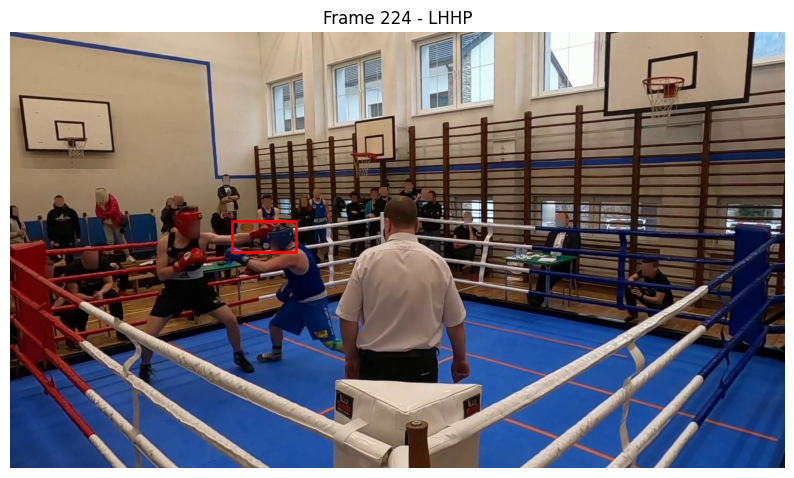

In [23]:
import matplotlib.patches as patches

video_path = list(data.keys())[1]
frame_index = data[video_path][0]["frame"]
label = data[video_path][0]["label"]
bbox = data[video_path][0]["bbox"]

container = av.open(video_path)

video_stream = container.streams.video[0]
for i,frame in enumerate(container.decode(video_stream)):
    if i==frame_index:
        img = frame.to_ndarray(format='rgb24')
        break
    
container.close()

# Display image with bounding box overlay
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)

# Extract bbox coordinates
x1, y1, x2, y2 = bbox
width = x2 - x1
height = y2 - y1

# Create rectangle patch
rect = patches.Rectangle(
    (x1, y1), width, height,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)

# Add the patch to the axes
ax.add_patch(rect)

ax.axis('off')
ax.set_title(f'Frame {frame_index} - {label}')
plt.show()



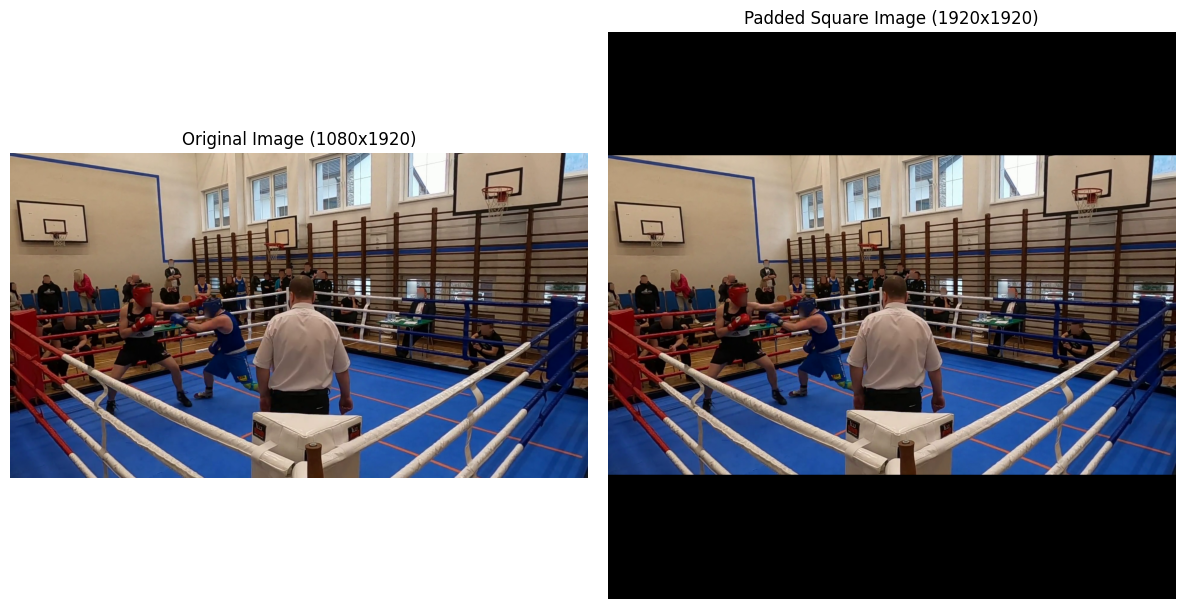

Original shape: (1080, 1920, 3)
Padded shape: (1920, 1920, 3)


In [24]:
def pad_image(img):
    h, w = img.shape[:2]

    # Determine the size of the square (use the larger dimension)
    max_dim = max(h, w)

    # Calculate padding needed
    if h < w:
        # Pad top and bottom
        pad_total = w - h
        pad_top = pad_total // 2
        pad_bottom = pad_total - pad_top
        pad_left = 0
        pad_right = 0
    else:
        # Pad left and right
        pad_total = h - w
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        pad_top = 0
        pad_bottom = 0

    # Pad the image with zeros (black) or you can use other values
    padded_img = np.pad(img, 
                        ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                        mode='constant', 
                        constant_values=0)
    return padded_img

padded_img = pad_image(img)

# Display the original and padded images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img)
axes[0].set_title(f'Original Image ({h}x{w})')
axes[0].axis('off')

axes[1].imshow(padded_img)
axes[1].set_title(f'Padded Square Image ({padded_img.shape[0]}x{padded_img.shape[1]})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Original shape: {img.shape}")
print(f"Padded shape: {padded_img.shape}")

In [26]:


video_path = list(data.keys())[1]
frame_index = data[video_path][0]["frame"]
label = data[video_path][0]["label"]

container = av.open(video_path)

imgs = []
video_stream = container.streams.video[0]
for i,frame in enumerate(container.decode(video_stream)):
    if i>=frame_index-8 and i<=frame_index+8:
        img = frame.to_ndarray(format='rgb24')
        imgs.append(img)
    
container.close()



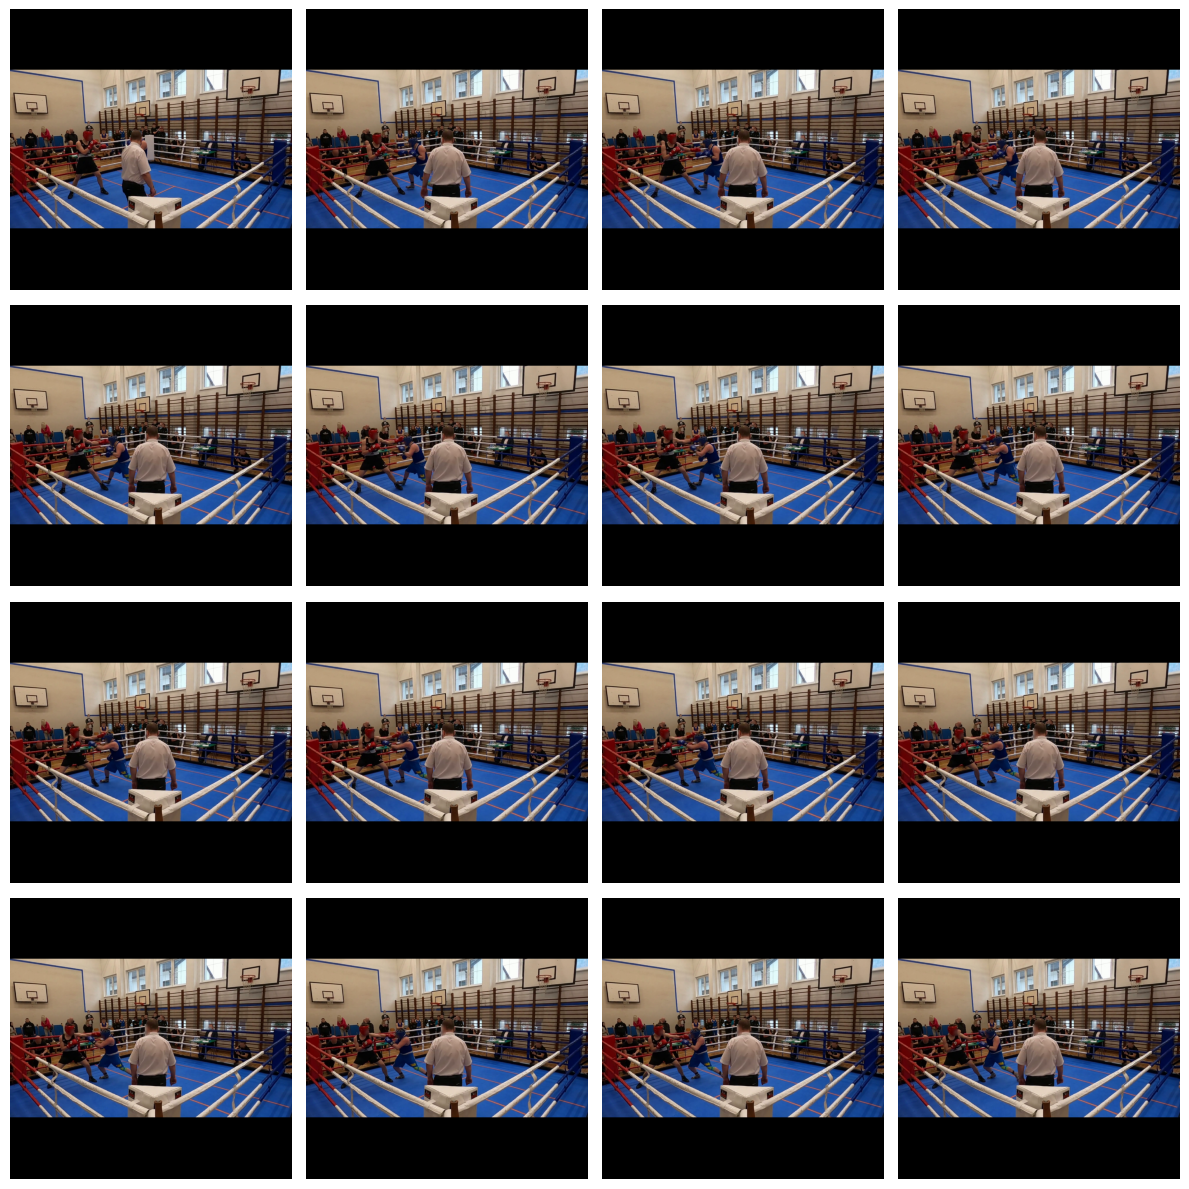

In [28]:
imgs = [pad_image(img) for img in imgs]

# Multiple frames (e.g., 16 frames in a grid)
# your list of frame arrays
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    ax.imshow(imgs[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def save_frames_to_mp4(frames, output_path, fps=30):
    """
    Save a list/array of RGB frames to an MP4 file.
    
    Args:
        frames: List or numpy array of frames, each shape (H, W, 3) uint8
        output_path: Path to save MP4 file
        fps: Frames per second (default 30)
    """
    # Convert to numpy array if it's a list
    if isinstance(frames, list):
        frames = np.stack(frames)
    
    # Get dimensions from first frame
    height, width = frames[0].shape[:2]
    
    # Create output container
    container = av.open(output_path, mode='w')
    stream = container.add_stream('h264', rate=fps)
    stream.width = width
    stream.height = height
    stream.pix_fmt = 'yuv420p'
    
    # Write frames
    for frame_array in frames:
        frame = av.VideoFrame.from_ndarray(frame_array, format='rgb24')
        for packet in stream.encode(frame):
            container.mux(packet)
    
    # Flush remaining packets
    for packet in stream.encode():
        container.mux(packet)
    
    container.close()

# Usage:
# save_frames_to_mp4(imgs, 'output_clip.mp4', fps=10)


In [33]:
# Resize images using PIL and convert back to ndarray
resized_frames = []
for img in imgs:
    # Convert numpy array to PIL Image
    pil_img = Image.fromarray(img)
    
    # Resize to target size (SIZE x SIZE)
    pil_img_resized = pil_img.resize((SIZE, SIZE), Image.BILINEAR)
    
    # Convert back to numpy array
    img_array = np.array(pil_img_resized)
    
    resized_frames.append(img_array)

clip = np.stack(resized_frames)
clip = clip.astype(np.uint8)
output_path = f"preprocessed_clips/train/{label}/clip_{1}"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, clip)

In [39]:
all_paths = list(data.keys())
count = 0
for video_path in all_paths:
    count += len(data[video_path])
count


4609

In [ ]:
count = 0

for video_path in data.keys():
    # Decode the video ONCE and store all frames we need
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    
    # Find all unique frame indices we need from this video
    needed_frames = set()
    for clip_data in data[video_path]:
        frame_index = clip_data["frame"]
        for offset in range(-8, 9):  # -8 to +8
            needed_frames.add(frame_index + offset)
    
    # Decode video once, store only needed frames
    frames_dict = {}
    for frame in container.decode(video_stream):
        if frame.index in needed_frames:
            frames_dict[frame.index] = frame.to_ndarray(format='rgb24')
    container.close()
    
    # Now process all clips from this video
    for clip_data in data[video_path]:
        frame_index = clip_data["frame"]
        label = clip_data["label"]
        
        # Extract the 17 frames we need
        imgs = []
        for offset in range(-8, 9):
            imgs.append(frames_dict[frame_index + offset])
        
        imgs = [pad_image(img) for img in imgs]
        pil_imgs = [Image.fromarray(img) for img in imgs]
        pil_imgs_resized = [img.resize((SIZE, SIZE), Image.BILINEAR) for img in pil_imgs]
        resized_frames = [np.array(img) for img in pil_imgs_resized]
        
        clip = np.stack(resized_frames)
        clip = clip.astype(np.uint8)
        
        if count < 3226:
            split = "train"
        elif count < 4839:
            split = "val"
        else:
            split = "test"
        
        output_path = f"preprocessed_clips/{split}/{label}/clip_{count}"
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        np.save(output_path, clip)
        
        count += 1
        print(f"Processed {count} clips", end="\r")
    
    # Free memory after processing each video
    del frames_dict

In [37]:
len(data[video_path])

100